# NEU502B Homework 2: fMRI preprocessing and analysis

The following homework assignment will require you to (1) load and visualize (f)MRI data in several different ways, (2) visualize several common confound variables, (3) create a design matrix capturing the experimental condition, and (4) use regression to model fMRI activity. Each of these problems builds on tools and ideas we've introduced in the in-class lab notebooks. We'll start by loading in some general-purpose Python modules, but you'll need to load additional modules to complete the problems (look to the lab notebooks for examples). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Problem 1: Visualization

fMRI datasets are complex and noisy, so it's important to visualize your data at every stage of analysis. We'll begin by loading in the dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) using [Nilearn](https://nilearn.github.io/). You'll need to change `data_dir` to a directory on your computer (or the server); if you've already downloaded this dataset in lab, you can set `data_dir` to the existing directory to save time.

In [258]:
from nilearn import datasets
from scipy.stats import zscore
from nilearn import datasets
from nilearn.plotting import (plot_anat, plot_epi, plot_roi,
                              plot_glass_brain, plot_stat_map,
                              plot_surf_stat_map, plot_img_on_surf)
from nilearn.image import (mean_img, load_img, index_img)
from nilearn.surface import vol_to_surf
from nilearn.masking import apply_mask

# Change this path to a directory on your computer!
data_dir = '../nilearn-data'

# Load the Haxby et al., 2001 data via Nilearn
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)

For the first set of exercises, we'll visualize (*a*) the T1-weighted anatomical image, (*b*) the EPI image averaged across time, (*c*) an EPI volume at time point 1312, and (*d*) a mask demarcating ventral temporal (VT) cortex.

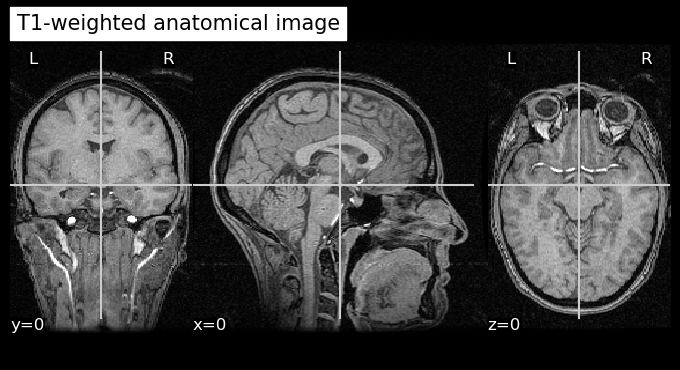

In [259]:
# Visualize the T1-weighted anatomical image here:
cut_coords = (0, 0, 0)
vmin, vmax = 0, 200
plot_anat(haxby_dataset.anat[0], cut_coords=cut_coords,
          vmin=vmin, vmax=vmax, title='T1-weighted anatomical image');

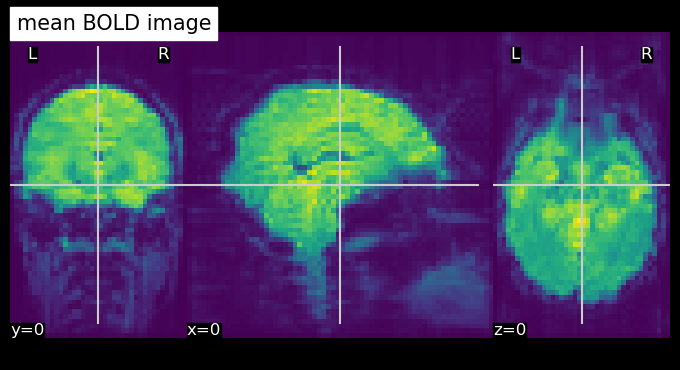

In [260]:
# Visualize the mean EPI image here:
cut_coords = (0, 0, 0)
plot_epi(mean_img(haxby_dataset.func[0]), cut_coords=cut_coords,
         cmap='viridis', title='mean BOLD image');

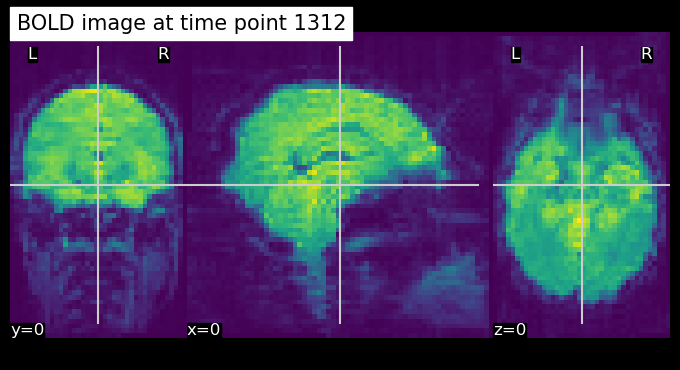

In [261]:
# Visualize EPI volume (time point) 1312 here:
cut_coords = (0, 0, 0)
epi_img = load_img(haxby_dataset.func[0])
epi_1312 = index_img(epi_img, 1312)
plot_epi(epi_1312, cut_coords=cut_coords,
         cmap='viridis', title='BOLD image at time point 1312')

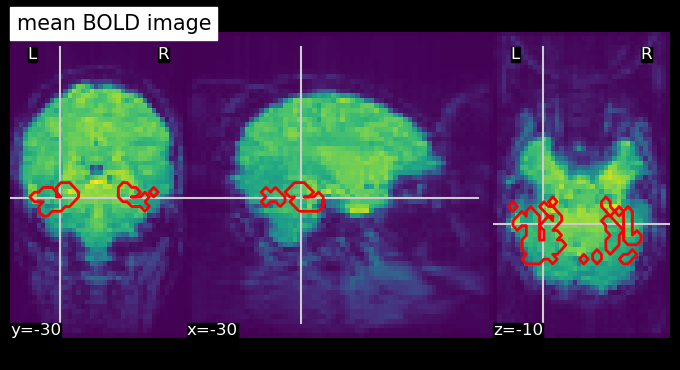

In [397]:
# Visualize the VT mask overlaid on the mean EPI here:
mask_vt = haxby_dataset.mask_vt[0]

cut_coords = (-30, -30, -10)
# cut_coords = (-43, -40, -12)

epi_fig = plot_epi(mean_img(haxby_dataset.func[0]), cut_coords=cut_coords,
         cmap='viridis', title='mean BOLD image');
epi_fig.add_contours(mask_vt, antialiased=True, linewidths=2,
                      levels=0, colors='red')

Next, we'll use [NiBabel](https://nipy.org/nibabel/) to directly load in the data as [NumPy](https://numpy.org/) arrays for manipulation in Python. First, we'll load in the VT mask as a boolean array. Inspect the shape of the functional data and mask, apply the mask to the functional data to get an array containing EPI time series for only VT cortex. Inspect the shape of the masked EPI data. Next, plot the mean time series in VT. Finally, without using Nilearn, create a "carpet plot" via [Power et al., 2017](https://doi.org/10.1016/j.neuroimage.2016.08.009) for VT data where the x-axis corresponds to time and the y-axis corresponds to voxels. Make sure to z-score each voxel's time series prior to plotting (e.g. using `zscore` from `scipy.stats`).

In [266]:
import nibabel as nib

# Use NiBabel to load functional data and VT mask:
func_data = nib.load(haxby_dataset.func[0]).get_fdata()
mask_vt_ = nib.load(mask_vt).get_fdata().astype(bool)

# Keep the VT mask voxel indices for later:
vt_indices = np.where(mask_vt_)

In [268]:
# Mask functional data and inspect shapes:
vt_time_series = func_data[vt_indices]
vt_time_series.shape #464, 1452

# You may want to transpose the masked data
# so that time points are in zeroth dimension:
vt_time_series = vt_time_series.T

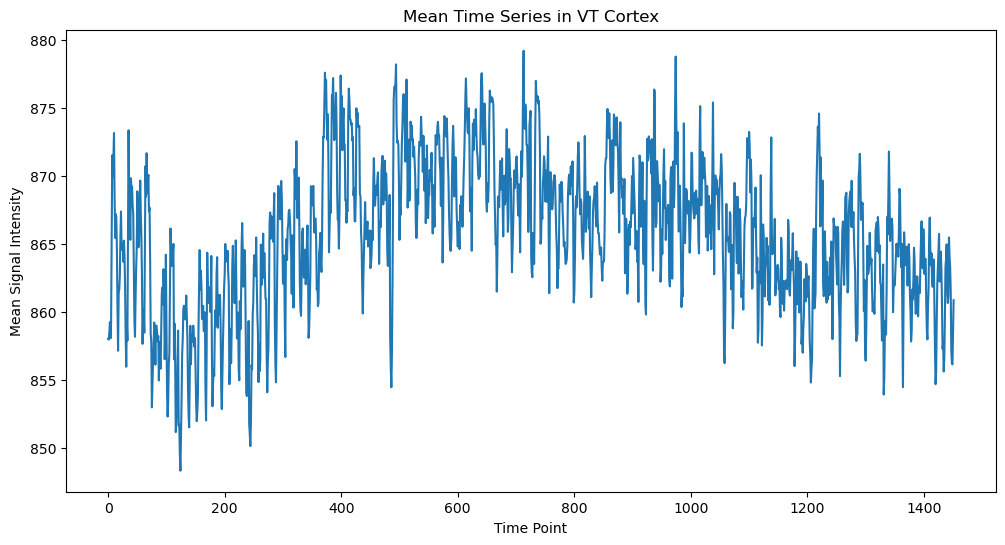

In [269]:
# Plot the mean time series in VT cortex here:
mean_vt_ts = (np.mean(vt_time_series, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(mean_vt_ts)
plt.title('Mean Time Series in VT Cortex')
plt.xlabel('Time Point')
plt.ylabel('Mean Signal Intensity')
plt.show()

Text(0, 0.5, 'Voxels')

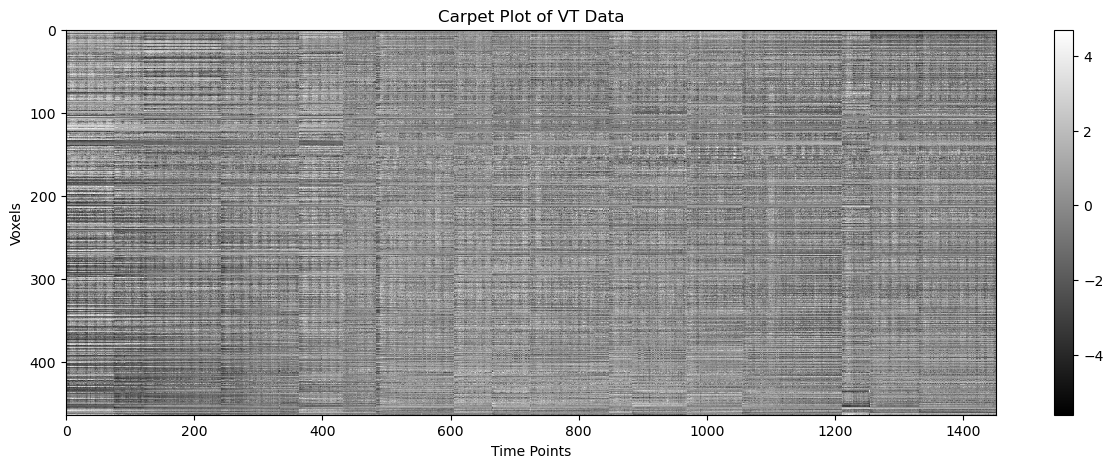

In [270]:
from scipy.stats import zscore

# Plot carpet plot of VT data here:
vt_ts_normalized = zscore(vt_time_series)

plt.figure(figsize=(15, 5))
plt.imshow(vt_ts_normalized.T, aspect='auto', cmap='gray', interpolation='none')
plt.colorbar()

plt.title('Carpet Plot of VT Data')
plt.xlabel('Time Points')
plt.ylabel('Voxels')

### Problem 2: Confounds
Unfortunately the publicly-available [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) dataset does not include confound variables. For this exercise, we'll take a short detour to visualize some confounds from the sample data accompanying the [Princeton Handbook for Reproducible Neuroimaging](https://brainhack-princeton.github.io/handbook/). These confounds variables are created by fMRIPrep during preprocessing.

In [271]:
# Load in the tabular confounds data
from pandas import read_table

confounds_f = 'sub-001_ses-01_task-faces_run-1_desc-confounds_timeseries.tsv'
df = read_table(confounds_f, sep='\t')
n_trs = len(df)

First, extract the six head motion parameters comprising translation (_x_-, _y_-, _z_-axes) and rotation (roll, pitch, yaw) from the counfounds table. Plot the translation and rotation time series below.

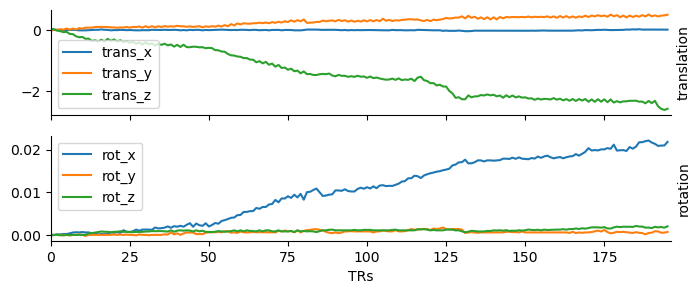

In [272]:
# Extract head motion parameters and visualize:
hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = df[hm_labels].values

fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)
axs[0].plot(hm[:, :3], label=hm_labels[:3])
axs[0].set_ylabel('translation')
axs[0].yaxis.set_label_position("right")
axs[0].legend()
axs[1].plot(hm[:, 3:], label=hm_labels[3:])
axs[1].set(xlabel='TRs', ylabel='rotation', xlim=(0, hm.shape[0]))
axs[1].yaxis.set_label_position("right")
axs[1].legend()
sns.despine()


Next, we'll obtain the aCompCor confounds returned by fMRIPrep. These correspond to principal component (PC) time series extracted from anatomically-defined masks cerebrospinal fluid (CSF) and white matter, which may reflect physiological fluctuations and other noise sources. Extract the first 5 aCompCor time series and plot them below.

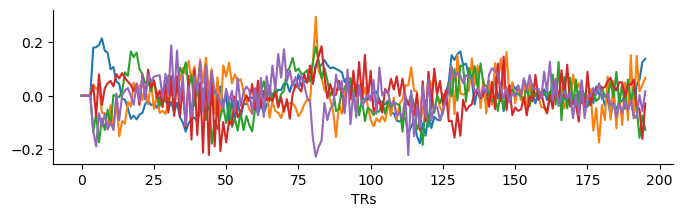

In [273]:
# Extract 5 anatomical CompCor signals and plot:
acompcor_n = 5
acompcor_labels = [f'a_comp_cor_0{n}' for n in range(acompcor_n)]
acompcor = df.filter(acompcor_labels).values

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(acompcor)
ax.set_xlabel('TRs')
sns.despine()

fMRI data often contain slow, non-neural fluctuations over time due to thermal noise and other measurement artifacts. One way to mitigate these slow noise fluctuations is to construct detrending variables. Here, we use 4th-degree [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) to construct a set of variables that will account for slow drifts in the signal.

In [274]:
# Construct 4th-degree Legendre polynomials
from scipy.special import eval_legendre

x_grid = np.linspace(-1, 1, n_trs)
degree = 4

polys = []
for n in np.arange(degree):
    polys.append(eval_legendre(n, x_grid))
polys = np.column_stack(polys)

Plot the polynomial detrending variables below on a `tr_grid` corresponding to the number of TRs.

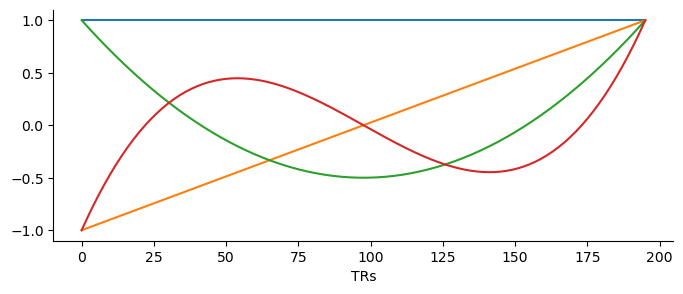

In [275]:
# Plot polynomial detrending variables on TR grid:
tr_grid = np.linspace(0, n_trs, n_trs)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(polys)
ax.set_xlabel('TRs')
sns.despine()

Finally, we'll compile all of these time series into a confound matrix. Column-stack the polynomial trends, head motion, and aCompCor variables into a single confound matrix and plot. 

Text(0, 0.5, 'Confounds')

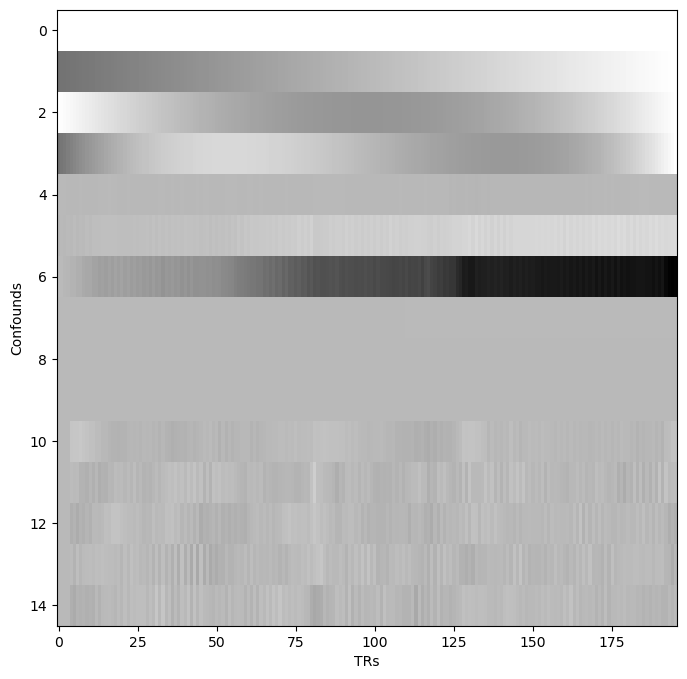

In [285]:
# Plot confound matrix:
confounds = np.column_stack((polys, hm, acompcor))

plt.figure(figsize = (8, 8))
plt.imshow(confounds.T, aspect='auto', cmap = 'grey')
plt.xlabel("TRs")
plt.ylabel("Confounds")

### Problem 3: Design

In fMRI analysis, we usually assume that the BOLD signal is the result of a linear time-invariant (LTI) system ([Boynton et al., 1996](http://www.jneurosci.org/content/16/13/4207)); in other words, we assume (1) the shape of the hemodynamic response is constant across time, and (2) the responses to successive stimuli superpose linearly (additively). Assumption #2 justifies using convolution in generating the predicted BOLD signal from a set of stimulus events, $x$, and a hemodynamic response function, $h$. Conceptually, what convolution does is add the entire HRF shape starting wherever there is a non-zero entry.

In the [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) experiment, participants were presented with images from 8 object categories (faces, cats, shoes, scissors, bottles, chairs, houses, and scrambled images) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. In the public dataset, these runs are concatenated into a single time series 1452 TRs in duration (although we will split it back into individual runs for certain processing steps). Below, we load in the stimulus and run labels and set some parameters for the experiment.

In [290]:
# Load in session metadata as pandas DataFrame
session = read_table(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Stimulus categories
categories = ['face', 'cat', 'shoe', 'scissors',
              'bottle', 'chair', 'house', 'scrambledpix']
n_categories = len(categories)

# Set some basic experimental parameters
tr = 2.5
n_trs = 1452
n_runs = 12
run_trs = 121

Next, we'll construct one boxcar time series for each of the 8 stimulus categories in the first run. Note that in this experiment each run only contains one block of stimuli per category. 

In [291]:
# Construct boxcar time series for the first run
run_id = 0
regressors = []
for category in categories:
    regressor = np.zeros(run_trs)
    regressor[np.where(stimuli[runs == 0] == category)] = 1
    regressors.append(regressor)
regressors = np.column_stack(regressors)

In the following cell, we plot the boxcar time series for each of the 8 stimulus categories. Note that we do not explicitly model the 'rest' fixation period.

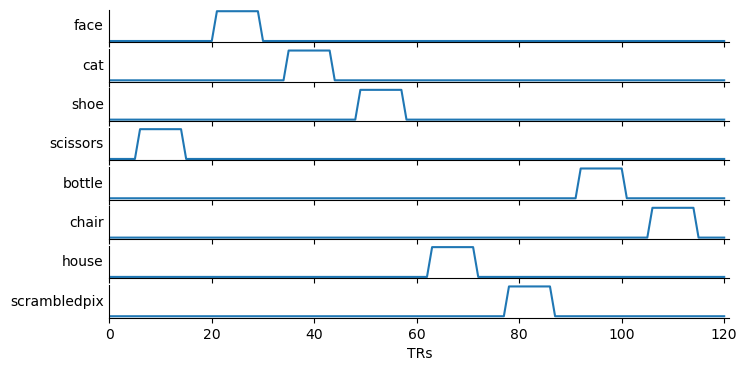

In [292]:
# Plot boxcar time series for the first run
fig, axs = plt.subplots(n_categories, 1, figsize=(8, 4),
                        sharex=True, sharey=True)
for i, (category, regressor) in enumerate(zip(categories, regressors.T)):
    axs[i].plot(regressor)
    axs[i].set(yticks=[])
    axs[i].set_ylabel(category, rotation=0, ha='right', va='center')
plt.xlabel('TRs')
plt.xlim(0, run_trs)
sns.despine()

Now, we'll load in a canonical hemodynamic response function (HRF) sampled at our 2.5-second TR.

In [293]:
# Load in HRF
from nilearn.glm.first_level import glover_hrf

tr = 2.5
hrf = glover_hrf(tr, oversampling=1, time_length=30)

The current boxcar time series capture hypothesized neural activity in response to the stimulus images, but do not reflect the sluggish BOLD response. For now, we'll keep focusing on the first run. In the following cell, convolve each of these boxcar time series with the canonical HRF to construct regressors for the fMRI data.

In [294]:
# Convolve first-run boxcar time series with HRF:
bolds = []

for regressor in regressors.T:
    bold = np.convolve(regressor, hrf)[:run_trs]
    bolds.append(bold)
bolds = np.column_stack(bolds)

Plot the predicted BOLD time series similarly to the boxcar time series above.

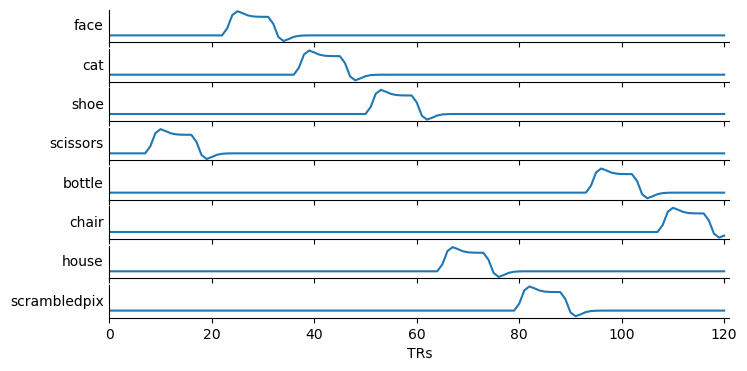

In [295]:
# Plot predicted BOLD time series for first run:
fig, axs = plt.subplots(n_categories, 1, figsize=(8, 4),
                        sharex=True, sharey=True)

for i, (category, bold) in enumerate(zip(categories, bolds.T)):
    axs[i].plot(bold)
    axs[i].set(yticks=[])
    axs[i].set_ylabel(category, rotation=0, ha='right', va='center')
plt.xlabel('TRs')
plt.xlim(0, run_trs)
sns.despine()

Now, combining elements of the code from previous cells, repeat this procedure of convolving each within-run boxcar time series with the HRF for all 12 runs. Vertical-stack all of these runwise regressors into a single design matrix `X` with shape `(1452, 8)`. Plot the eight regressors across the entire experiment.

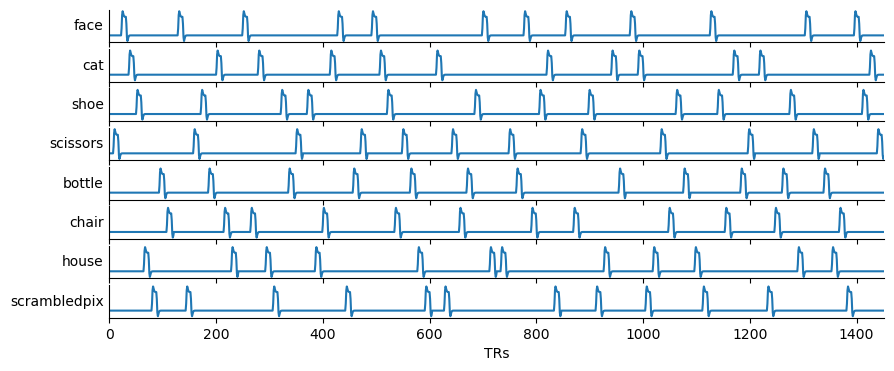

In [411]:
# Loop through runs, apply HRF, and re-stack:
bolds_all = []
regressors_all = []

for run in range(n_runs):
    regressors = []
    for category in categories:
        regressor = np.zeros(run_trs)
        regressor[np.where(stimuli[runs == run] == category)] = 1
        regressors.append(regressor)
    regressors = np.column_stack(regressors)
    regressors_all.append(regressors)
    
    bolds = []
    for regressor in regressors.T:
        bold = np.convolve(regressor, hrf)[:run_trs]
        bolds.append(bold)
    bolds = np.column_stack(bolds)

    bolds_all.append(bolds)
    
bolds_all = np.row_stack(bolds_all)
regressors_all = np.row_stack(regressors_all)

# Plot regressors across entire experiment:
fig, axs = plt.subplots(n_categories, 1, figsize=(10, 4),
                        sharex=True, sharey=True)

for i, (category, bold) in enumerate(zip(categories, bolds_all.T)):
    axs[i].plot(bold)
    axs[i].set(yticks=[])
    axs[i].set_ylabel(category, rotation=0, ha='right', va='center')
plt.xlabel('TRs')
plt.xlim(0, n_trs)
sns.despine()


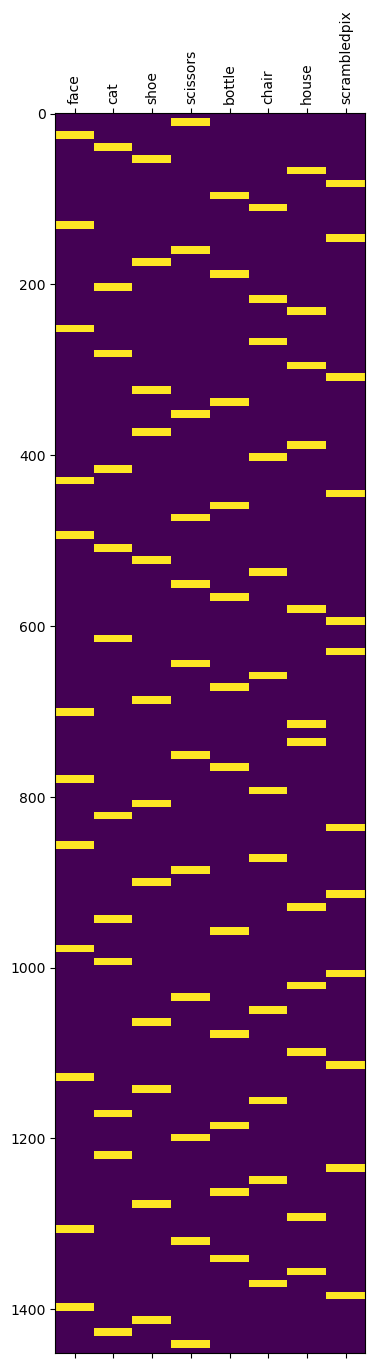

In [366]:
# fig, ax = plt.subplots(n_categories, 1, figsize=(4, 4))

plt.matshow(regressors_all, aspect = 'auto')
plt.xticks(np.arange(n_categories), labels=categories, rotation=90)
plt.show()
# plt.set_xticklabels(categories, rotation = 45)

When designing an fMRI experiment, it's important minimize collinearity among your regressors of interest to ensure that your regression model can accurately assign variance to each regressor. One simple way to evaluate collinearity is to compute the pairwise correlations (shaped `(8, 8)`) among your regressors of interest in `X`. Use `np.corrcoef` to compute the pairwise correlations among regressors and plot the resulting correlation matrix; similarly, you could compute the convariance matrix using `np.cov` or `X.T @ X`, or use a more sophisticated metric like [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (e.g. [`variance_inflation_factor`](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) in `statsmodels.stats.outliers_influence`).

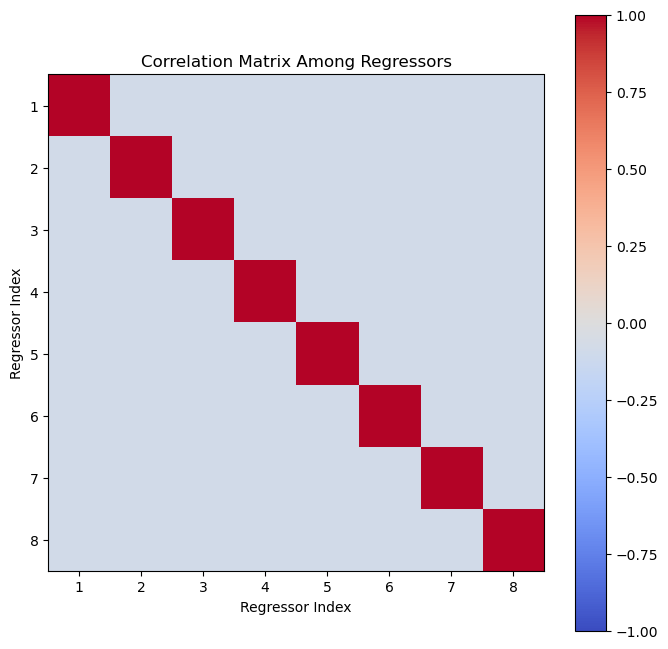

In [155]:
# Compute correlation matrix and plot:
correlation_matrix = np.corrcoef(regressors_all, rowvar=False)

plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix Among Regressors')
plt.xlabel('Regressor Index')
plt.ylabel('Regressor Index')
plt.xticks(ticks=np.arange(len(regressors[0])), labels=np.arange(1, len(regressors[0]) + 1))
plt.yticks(ticks=np.arange(len(regressors[0])), labels=np.arange(1, len(regressors[0]) + 1))

### Problem 4: Regression

Now that we have a set of regressors (i.e. predictors) capturing the object categories in our experimental design, we'll use a simple regression analysis to model each voxel time series in the fMRI data. In fMRI analysis, this is often referred to as the mass univariate general linear model or GLM. The goal is to discover which voxels are most responsive to certain object categories such as faces or houses. Recall that the publicly-available [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) unfortunately does not include confound variables, so here we'll focus mostly on the regressors of interest. However, we can include 4th-order Legendre polynomials in the same way as above to mitigate any slow drifts.

In [306]:
# Construct 4th-degree Legendre polynomials matching number of TRs:
x_grid = np.linspace(-1, 1, n_trs)
degree = 4

polys = []
for n in np.arange(degree):
    polys.append(eval_legendre(n, x_grid))
polys = np.column_stack(polys)

Stack these polynomial detrending variables alongside the eight category regressors in your design matrix `X`. Keep track of which columns correspond to variables of interest and which correspond to confound variables.

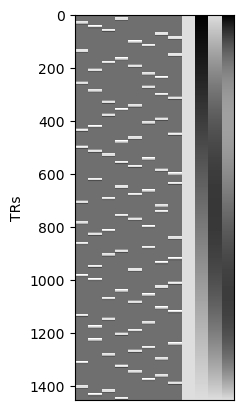

In [385]:
# Stack detrending variables alongside category regressors:
X = np.column_stack((bolds_all,
                     polys))

fig, ax = plt.subplots(figsize=(2.5, 5))
ax.matshow(np.repeat(X, 50, axis=1), cmap='binary_r')
ax.set(xticks=[], ylabel='TRs');

Next, we need to make sure that our fMRI data are prepared. For the sake of computational efficiency, we'll focus on the voxels in VT cortex, rather than running a whole-brain analysis across all voxels. Use the functional data extracted from VT cortex from Part 1. Split the VT data into separate runs, z-score the voxelwise time series within each run, the re-stack the runs.

In [386]:
# Z-score each run and re-stack:
vt_ts_z = []

# Split the data into runs, z-score within each run, and append to the list
for i in range(n_runs): 
    run_data = vt_time_series[np.where(runs == i)]
    
    # Z-score the data within each run
    z_scored_run = zscore(run_data, axis=0)
    vt_ts_z.append(z_scored_run)

# Concatenate the z-scored data for all runs back into one array
vt_ts_z = np.row_stack(vt_ts_z)

Finally, we should be ready to run our regression. First, to keep things as simple as possible, we'll run the regression using `lstsq` from `np.linalg`. Use `lstsq` to compute the regression coefficients (i.e. "beta values") for the eight category regressors.

In [404]:
# Use least-squares to compute betas:
b, _, _, _ = np.linalg.lstsq(X, vt_ts_z, rcond=-1)
print(b.shape)

(12, 464)


Now, use a contrast vector to perform two comparisons: (1) faces > all seven other categories, and (2) houses > all seven other categories. Remember, these contrast vectors should sum to zero. Multiple the contrast vector by the corresponding betas and sum across betas to compute the contrast; each comparison should result in a single map for VT cortex.

In [391]:
# Create contrast vectors:
cv_face = np.zeros(X.shape[1])
cv_face[0] = 1
cv_face[1:8] = -1/7

cv_house = np.zeros(X.shape[1])
cv_house[0:8] = -1/7
cv_house[6] = 1

# Apply contrast vectors to betas:
contrast_face = (b.T @ cv_face[:, np.newaxis])
contrast_house = (b.T @ cv_house[:, np.newaxis])

In [392]:
brain_volume_shape = mask_vt_.shape
brain_image = np.zeros(brain_volume_shape)

for val, coords in zip(contrast_face, zip(*vt_indices)):
    brain_image[coords] = val

# Now create a Nifti1Image from the 3D array
niimg_like = nib.Nifti1Image(brain_image, affine=np.eye(4))

/tmp/ipykernel_123382/1969944390.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  brain_image[coords] = val


Finally, reinsert these beta values back into a full NIfTI image and use `plot_stat_map` from `nilearn.plotting` to visualize the resulting maps for the faces-vs-all contrast and the houses-vs-all contrast. Try using the T1-weighted anatomical image as the `bg_img`, then pick a good set of coordinates for visualizing VT (e.g. `cut_coords = (-43, -40, -12)`). What do you notice about the anatomical localization of face-responsive versus house-responsive areas of VT cortex?

/tmp/ipykernel_123382/1531486281.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  brain_image[coords] = val


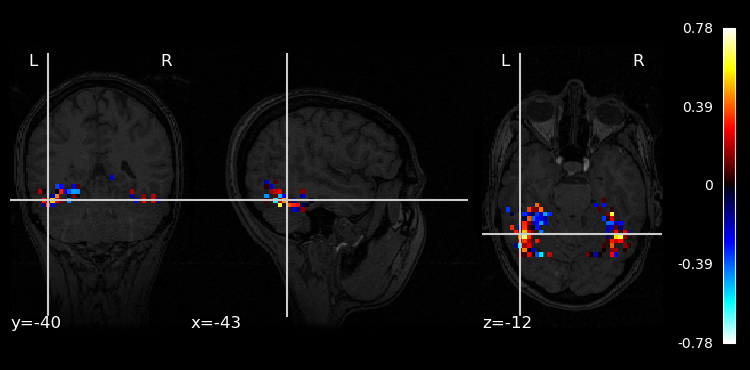

In [409]:
from nilearn.plotting import plot_stat_map

cut_coords = (-43, -40, -12)

# Reinsert VT face contrast map into full NIfTI image:
brain_volume_shape = mask_vt_.shape
brain_image = np.zeros(brain_volume_shape)

for val, coords in zip(contrast_face, zip(*vt_indices)):
    brain_image[coords] = val

affine = nib.load(haxby_dataset.func[0]).affine
niimg_face = nib.Nifti1Image(brain_image, affine=affine)

# Plot face-vs-all contrast:
plot_stat_map(niimg_face, bg_img = haxby_dataset.anat[0], 
              cut_coords=cut_coords)

In [402]:
brain_volume_shape

(40, 64, 64)

/tmp/ipykernel_123382/4000920570.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  brain_image[coords] = val


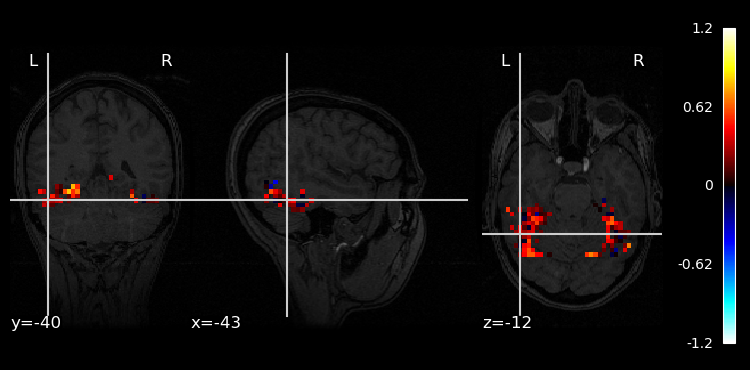

In [410]:
# Reinsert VT house contrast map into full NIfTI image:
brain_volume_shape = mask_vt_.shape
brain_image = np.zeros(brain_volume_shape)

for val, coords in zip(contrast_house, zip(*vt_indices)):
    brain_image[coords] = val

affine = nib.load(haxby_dataset.func[0]).affine
niimg_house = nib.Nifti1Image(brain_image, affine=affine)

# Plot house-vs-all contrast:
plot_stat_map(niimg_house, bg_img = haxby_dataset.anat[0], 
              cut_coords=cut_coords)